In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import pickle
from glob import glob
import os
from keras.preprocessing.image import load_img

import torch
from torch.utils.data import DataLoader, Dataset

from model import UNetResNet34, predict_proba
from utils import load_checkpoint
from dataset import pad_reflect, unpad_reflect, unpad_reflect256, TgsDataSet
from postprocess import rle_encode

from importlib import reload
import metrics
reload(metrics)
from metrics import *

from augmentation_huang import do_center_pad_to_factor

from matplotlib import pyplot as plt

%matplotlib inline

/home/endi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## look at trainset validset with ground-truth

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#device = torch.device("cpu")
#torch.set_num_threads(20)

img_size_target = 101#128,256

SEED = 1234#5678#4567#3456#2345#1234

In [3]:
# choose best threshold using validset
with open('../data/processed/dataset_%d.pkl'%SEED, 'rb') as f:
    ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = pickle.load(f)


In [4]:
# valid data & its flipped version
val_ds = TgsDataSet(x_valid, y_valid, transform=False)
val_dl = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

## x.shape = [1, 128, 128]
val_ds_flip = TgsDataSet(np.array([x[:,:,::-1] for x in x_valid]), y_valid, transform=False)
val_dl_flip = DataLoader(
    val_ds_flip,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

In [5]:
# load the trained model
net = UNetResNet34(pretrained=True).cuda(device=device)
checkpoint_path = 'checkpoint/1006_v1_seed1234_849/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

In [6]:
net.set_mode('valid')
preds_valid = (predict_proba(net, val_dl, device) + \
              np.array([x[:,::-1] for x in predict_proba(net, val_dl_flip, device)])) / 2

In [7]:
# keep only nonzero mask images
_nonzero_index = y_valid.reshape(400, 101*101).sum(axis=1)!=0
preds_valid = preds_valid[_nonzero_index, :, :]
y_valid = y_valid[_nonzero_index, :, :, :]
x_valid = x_valid[_nonzero_index, :, :, :]

In [12]:
# postprocess 62, 91, 142, 176, 187 to zero-mask
for i in [62, 91, 142, 176, 187]:#176
    preds_valid[i] = np.zeros((256, 256))

In [13]:
preds_valid.shape, y_valid.shape, x_valid.shape

((244, 256, 256), (244, 1, 101, 101), (244, 1, 101, 101))


[0.81188525 0.81762295 0.81844262 0.81967213 0.82008197 0.82254098
 0.82295082 0.82213115 0.82090164 0.82172131 0.8204918  0.82172131
 0.82295082 0.82418033 0.82213115 0.82131148 0.81885246 0.81762295
 0.81680328 0.81639344 0.81516393 0.81639344 0.81352459 0.81188525
 0.80983607 0.80737705 0.80245902 0.79877049 0.79713115 0.79344262
 0.78196721]


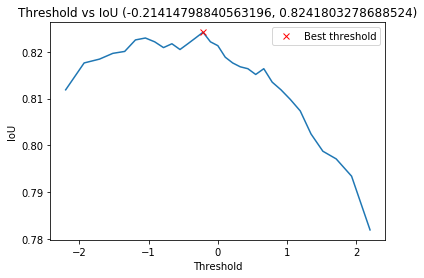

In [14]:
thresholds_ori = np.linspace(0.1, 0.9, 31)#np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori))

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)

#y_valid = np.array([do_center_pad_to_factor(image.reshape(101, 101), factor=32).reshape(1, 128, 128) \
#                    for image in y_valid]) #if use Huang's augmentation, otherwise comment this line
preds_valid = np.array([unpad_reflect256(image) for image in preds_valid])
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [15]:
threshold_best, iou_best

(-0.21414798840563196, 0.8241803278688524)

In [23]:
# prob to 0-1
preds_valid = [np.round(_preds_valid > threshold_best) for _preds_valid in tqdm_notebook(preds_valid)]


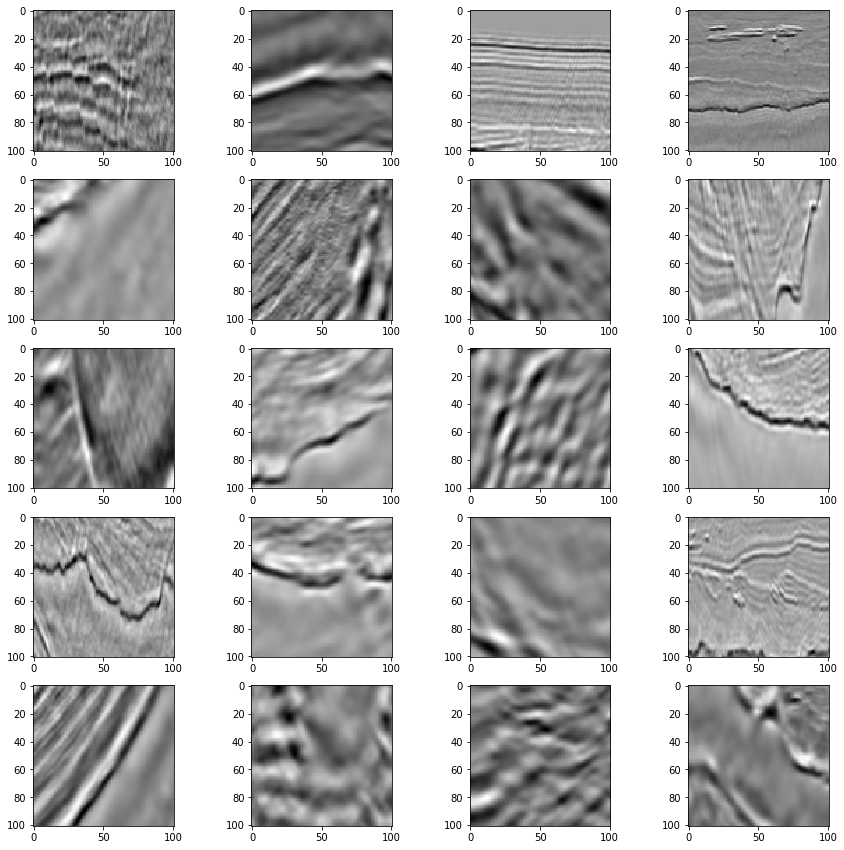

In [26]:
# raw image
fig=plt.figure(figsize=(15, 15))
for i, j in enumerate(range(start, end)):
    img_arr = x_valid[j]
    ax = fig.add_subplot(5, 4, i+1)
    #ax.title.set_text('augment mask')
    #plt.imshow(truth[0, 0], cmap='gray')
    plt.imshow(img_arr.reshape(101, 101), cmap='binary')

In [25]:
start, end = 60,80

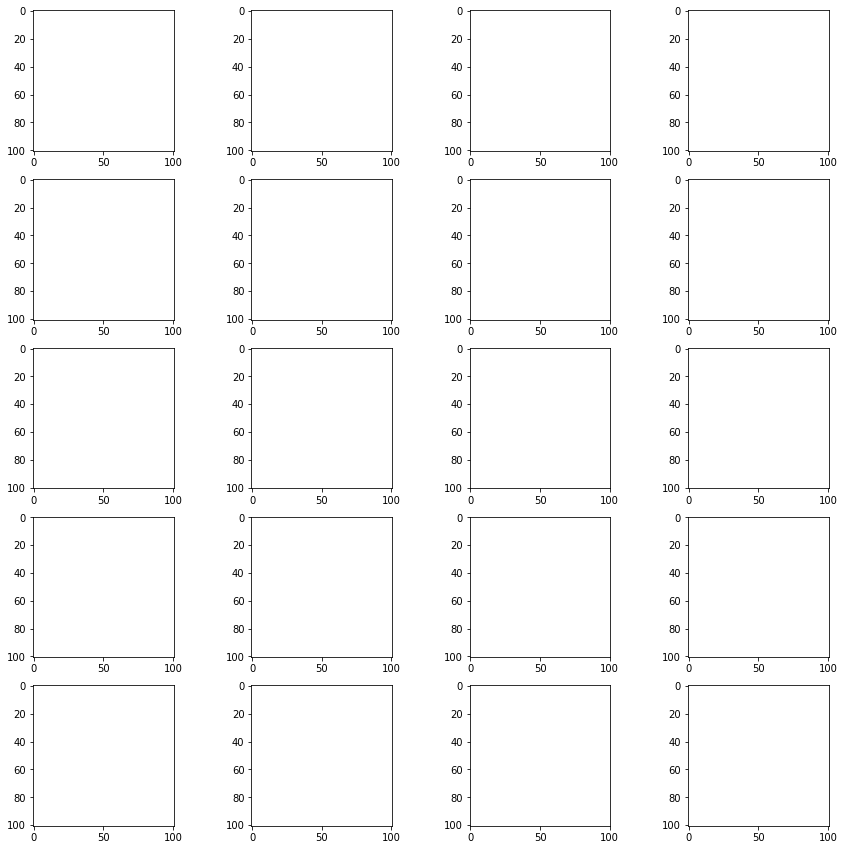

In [27]:
# preds
fig=plt.figure(figsize=(15, 15))
for i, j in enumerate(range(start, end)):
    img_arr = preds_valid[j]
    ax = fig.add_subplot(5, 4, i+1)
    #ax.title.set_text('augment mask')
    #plt.imshow(truth[0, 0], cmap='gray')
    plt.imshow(img_arr.reshape(101, 101).astype(np.int), cmap='binary')

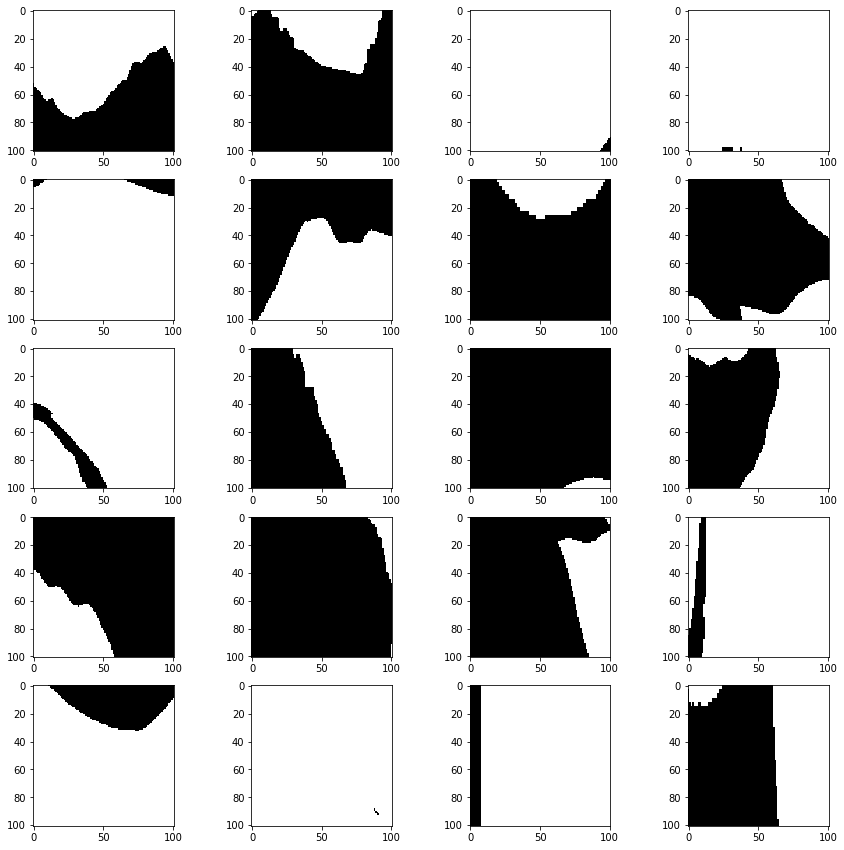

In [34]:
# ground truth
fig=plt.figure(figsize=(15, 15))
for i, j in enumerate(range(start, end)):
    img_arr = y_valid[j]
    ax = fig.add_subplot(5, 4, i+1)
    #ax.title.set_text('augment mask')
    #plt.imshow(truth[0, 0], cmap='gray')
    plt.imshow(img_arr.reshape(101, 101), cmap='binary')

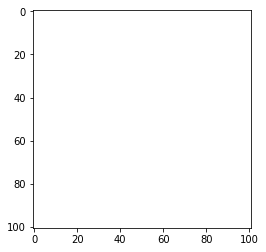

In [20]:
# bad predictions:
# 62, 91, 142, 176, 187

k = 91

plt.imshow(preds_valid[k].reshape(101,101).astype(np.int), cmap='binary')

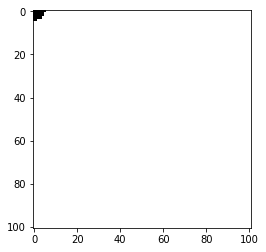

In [21]:
plt.imshow(y_valid[k].reshape(101,101), cmap='binary')

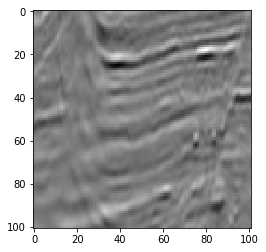

In [22]:
plt.imshow(x_valid[k].reshape(101,101), cmap='binary')

## for the testset and predictions

In [85]:
# testset
img_ids = [f.split('/')[-1].split('.')[0] for f in glob('../data/raw/test_images/images/*.png')]

x_test = [(np.array(load_img("../data/raw/test_images/images/{}.png".format(idx), \
                                      color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(img_ids)]

In [86]:
# the best model's predictions (Note: including zero-mask-imgs)
with open('prediction/1008_v1_seed1234_snapshot_cycle0.pkl', 'rb') as f:
    preds_test, threshold_best = pickle.load(f)

In [87]:
y_test = [np.round(unpad_reflect256(preds_test[i]) > threshold_best) for i, idx in enumerate(tqdm_notebook(img_ids))]

## pred_prob to preds by threashold_best, and unpad to 101x101
#unpad_pred_dict = {idx: np.round(unpad_reflect256(preds_test[i]) > threshold_best) for i, idx in enumerate(tqdm_notebook(img_ids))}


In [90]:
y_test[0].shape, x_test[0].shape, len(y_test)

((101, 101), (101, 101), 18000)

In [89]:
start, end = 0, 20

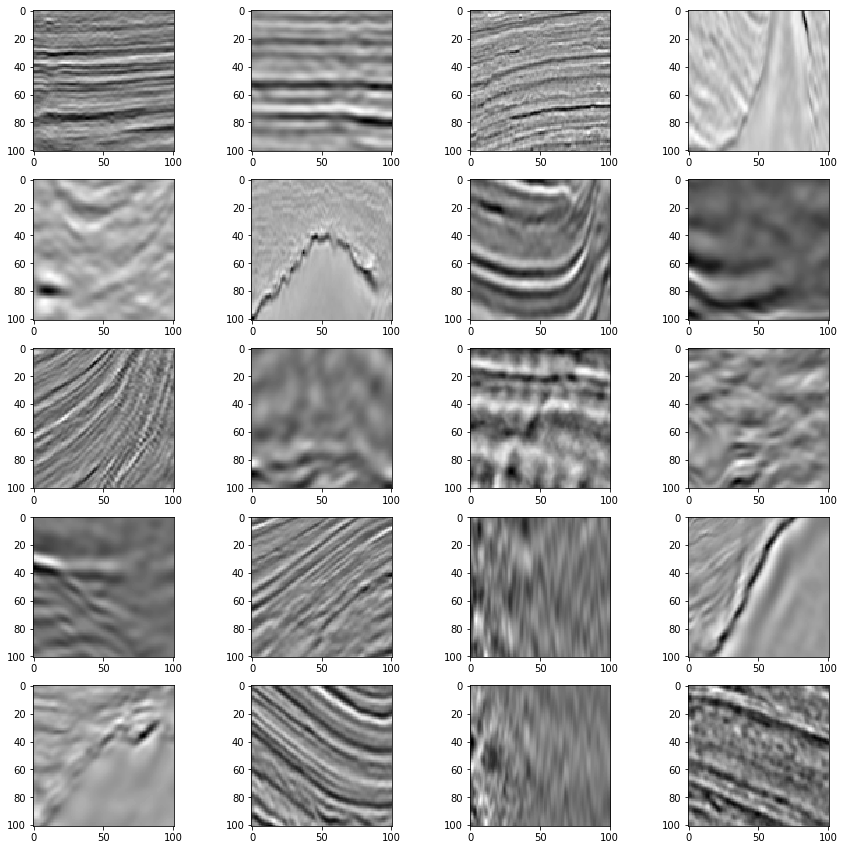

In [91]:
fig=plt.figure(figsize=(15, 15))
for i, j in enumerate(range(start, end)):
    img_arr = x_test[j]
    ax = fig.add_subplot(5, 4, i+1)
    #ax.title.set_text('augment mask')
    #plt.imshow(truth[0, 0], cmap='gray')
    plt.imshow(img_arr, cmap='binary')

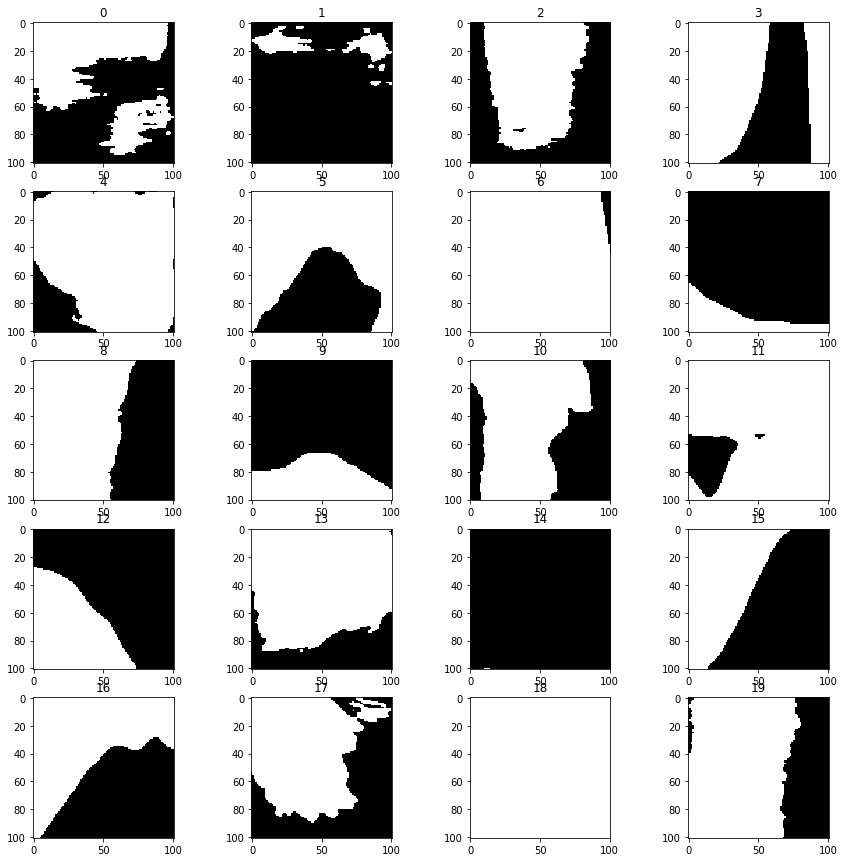

In [98]:
fig=plt.figure(figsize=(15, 15))
for i, j in enumerate(range(start, end)):
    img_arr = y_test[j]
    ax = fig.add_subplot(5, 4, i+1)
    ax.set_title(str(start+i))
    #ax.title.set_text('augment mask')
    #plt.imshow(truth[0, 0], cmap='gray')
    plt.imshow(img_arr.astype(np.int64), cmap='binary')

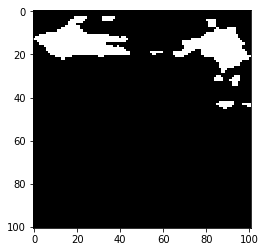

In [104]:
k = 1
plt.imshow(y_test[k].reshape(101,101).astype(np.int64), cmap='binary')